In [18]:
# import library


import warnings
warnings.filterwarnings("ignore")

import os
import yfinance as yf
import pandas as pd
import numpy as np
import talib
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from sklearn import linear_model
from sklearn.metrics import accuracy_score,log_loss,precision_score,roc_auc_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# download data

In [25]:
df=yf.download(tickers='HDFCBANK.NS', start_date='2005-1-1', end_date='2021-1-1', index_col=0, parse_dates=True)

[*********************100%***********************]  1 of 1 completed


In [28]:
print(df)

df1 = df.copy()

stock_high = df['High']
stock_low = df['Low']
stock_open = df['Open']
stock_close = df['Close']
stock_volume = df['Volume']


                   Open         High       Low        Close    Adj Close  \
Date                                                                       
1996-01-01     3.030000     3.030000     2.925     2.980000     2.428210   
1996-01-02     2.980000     3.025000     2.950     2.975000     2.424136   
1996-01-03     2.975000     2.995000     2.950     2.985000     2.432283   
1996-01-04     2.985000     2.980000     2.940     2.965000     2.415987   
1996-01-05     2.965000     2.980000     2.950     2.960000     2.411913   
...                 ...          ...       ...          ...          ...   
2021-05-20  1458.349976  1465.900024  1428.500  1432.800049  1432.800049   
2021-05-21  1443.000000  1501.900024  1443.000  1497.300049  1497.300049   
2021-05-24  1503.250000  1520.449951  1498.500  1509.949951  1509.949951   
2021-05-25  1510.500000  1513.750000  1470.500  1478.949951  1478.949951   
2021-05-26  1480.000000  1487.000000  1470.000  1477.050049  1477.050049   

           

MACD Indicator

In [29]:
macd, macdsignal, macdhist = talib.MACD(stock_close, fastperiod=12, slowperiod=26, signalperiod=9)
dict = {'MACD': macd, 'MSIG': macdsignal}
macdata = []
macdata = pd.DataFrame(data=dict)
macdata.dropna(inplace=True)
macdata['MACD_Signal1'] = macdata.apply(lambda x : 1 if x['MACD'] > x['MSIG'] else 0, axis = 1)
n_days = len(macdata['MACD'])
Signal = macdata['MACD_Signal1']
psy = []

# Generate signals
for d in range(0, n_days):
    
    if Signal[d] == 1:
        psycology = 1
        psy.append(psycology)
    
    elif Signal[d] == 0:
        psycology = 0
        psy.append(psycology)
        
macdata['MACD_Signal'] = psy
del macdata['MACD_Signal1']

dict = {'MHIST': macdhist, 'PrevMHIST': macdhist.shift(1)}
machdata = []
machdata = pd.DataFrame(data=dict)
machdata.dropna(inplace=True)
machdata['MHIST_Signal1'] = machdata.apply(lambda x : 1 if x['MHIST'] > x['PrevMHIST'] else 0, axis = 1)
n_days = len(machdata['MHIST'])
Signal = machdata['MHIST_Signal1']
psy = []

for d in range(0, n_days):
    
    if Signal[d] == 1:
        psycology = 1
        psy.append(psycology)
    
    elif Signal[d] == 0:
        psycology = 0
        psy.append(psycology)
        
machdata['MHIST_Signal'] = psy
del machdata['MHIST_Signal1']

RSI Indicator

In [30]:
rsi = talib.RSI(stock_close, timeperiod=14)
dict = {'Close': stock_close, 'RSI': rsi }
rsidata = []
rsidata = pd.DataFrame(data=dict)
rsidata.dropna(inplace=True)

# Generate signals
rsidata['rsi1'] = rsidata.apply(lambda x : 1 if x['RSI'] < 30 else 0, axis=1)
rsidata['rsi2'] = rsidata.apply(lambda x : -1 if x['RSI'] > 70 else 0, axis=1)
rsidata['Sign1'] = rsidata.apply(lambda x : x['rsi1'] + x['rsi2'], axis=1)
n_days = len(rsidata['RSI'])
Signal = rsidata['Sign1']
psy = []

for d in range(0, n_days):
    if Signal[d] == 1:
        psycology = 1
        psy.append(psycology)
    
    elif Signal[d] == -1:
        psycology = 0
        psy.append(psycology)
    
    elif Signal[d] == 0:
        psycology = 0
        psy.append(psycology)
        
rsidata['Psycology'] = psy
del rsidata['Sign1']
del rsidata['rsi1']
del rsidata['rsi2']

Bollinger Bands Indicator

In [31]:
upper, middle, lower = talib.BBANDS(stock_close, timeperiod=14)
dict = {'Close': stock_close, 'Middle': middle, 'Upper': upper, 'Lower': lower }
bbdata = []
bbdata = pd.DataFrame(data=dict)
bbdata.dropna(inplace=True)

#Generate the Long and Short Signals
n_days = len(bbdata['Middle'])
cash = 1
stock = 0
position = []
spread = stock_close
ma = middle
upper_band = upper
lower_band = lower

for d in range(0, n_days):
    
    # Long if spread < lower band & if not bought yet
    if spread[d] < lower_band[d] and cash == 1:
        signal = 1
        cash = 0
        stock = 1
        position.append(signal)
        
        
    # Take Profit if spread > moving average & if already bought
    elif spread[d] > ma[d] and stock == 1:
        signal = 3
        cash = 1
        stock = 0
        position.append(signal)
        
    # Short if spread > upper band and no current position
    elif spread[d] > upper_band[d] and cash == 1:
        signal = -1
        cash = 0
        stock = -1
        position.append(signal)
        
    elif spread[d] < ma[d] and stock == -1:
        signal = 3
        cash = 1
        stock = 0
        position.append(signal)
    
    else:
        signal = 0
        position.append(signal)
        
bbdata['Position1'] = position
bbdata['Position1'] = bbdata['Position1'].replace(to_replace=0, method= 'ffill')
bbdata['Position1'] = bbdata['Position1'].replace(3,0)
bbdata['Position'] = bbdata['Position1']
del bbdata['Position1']
t_days = len(bbdata['Middle'])
Signal = bbdata['Position']
pos = []

for d in range(0, t_days):
    if Signal[d] == 0:
        strategy = 0
        pos.append(strategy)
    
    elif Signal[d] == 1:
        strategy = 1
        pos.append(strategy)
    
    elif Signal[d] == -1:
        strategy = 0
        pos.append(strategy)

bbdata['Strategy'] = pos



Force Index Indicator

In [32]:
def ForceIndex(Volume, Close):
    dict = {'Volume': Volume, 'Close': Close}
    df = pd.DataFrame(data=dict)
    df.dropna(inplace=True)
    FI = df['Volume']*(df['Close'] - df['Close'].shift(1))
    return FI

    
fi = ForceIndex(stock_volume,stock_close)
efi = talib.EMA(fi, timeperiod=13)
dict = {'Close': stock_close, 'EFI': efi }
efidata = []
efidata = pd.DataFrame(data=dict)
efidata.dropna(inplace=True)
efidata['efi_sign'] = efidata.apply(lambda x : 1 if x['EFI'] > 0 else -1, axis=1)
n_days = len(efidata['EFI'])
Signal = efidata['efi_sign']
psy = []


for d in range(0, n_days):
    if Signal[d] == 1:
        psycology = 1
        psy.append(psycology)
    
    elif Signal[d] == -1:
        psycology = 0
        psy.append(psycology)
      
efidata['Psycology'] = psy
del efidata['efi_sign']

Classify Next Day Stock Move

In [33]:
stock_move = stock_close.shift(-1)
dict = {'Close': stock_close, 'Move': stock_move}
sdmdata = []
sdmdata = pd.DataFrame(data=dict)
sdmdata.dropna(inplace=True)
sdmdata['sign'] = sdmdata.apply(lambda x : 1 if np.log(x['Move']/x['Close']) > 0 else -1, axis=1)
n_days = len(sdmdata['Move'])
Signal = sdmdata['sign']
psy = []

for d in range(0, n_days):
    if Signal[d] == 1:
        psycology = 1
        psy.append(psycology)
    
    elif Signal[d] == -1:
        psycology = 0
        psy.append(psycology)
         
sdmdata['Next Week Move'] = psy
del sdmdata['sign']

Technical Indicator and Next Day's Stock Move

In [35]:
Close = pd.DataFrame({'Close': stock_close})
NWM = pd.DataFrame({'Next Week Move': sdmdata['Next Week Move']})
MACD = pd.DataFrame({'MACD': macdata['MACD_Signal']})
MHIST = pd.DataFrame({'MHIST': machdata['MHIST_Signal']})
RSI = pd.DataFrame({'RSI': rsidata['Psycology']})
BB = pd.DataFrame({'BB': bbdata['Strategy']})
FI = pd.DataFrame({'FI': efidata['Psycology']})


merge1 = pd.merge(Close, NWM, left_index=True, right_index=True, how='outer')
merge2 = pd.merge(merge1, MACD, left_index=True, right_index=True, how='outer')

merge3 = pd.merge(merge2, MHIST, left_index=True, right_index=True, how='outer')
merge4 = pd.merge(merge3, RSI, left_index=True, right_index=True, how='outer')
merge5 = pd.merge(merge4, BB, left_index=True, right_index=True, how='outer')
df_daily = pd.merge(merge5, FI, left_index=True, right_index=True, how='outer')

df_daily.dropna(inplace=True)

Random Forest Algorithm 

---------REASONS TO CHOOSE------- 
1. It produces results even without hyperparameter tuning.
2. It searches for the best feature among a random subset of features, and
3. Adds additional randomness to the model.


In [39]:
x = df_daily[['MACD', 'MHIST', 'RSI', 'BB', 'FI']]
y = df_daily['Next Week Move']
z = df_daily['Close']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1124, test_size=0.25)
model = RandomForestClassifier(n_estimators=100,max_depth=5,max_features=None,max_leaf_nodes=None,
                               min_samples_leaf=1, min_samples_split=2,oob_score=True,random_state=1124)
model.fit(x_train,y_train)

training_score = model.score(x_train, y_train)
test_score = model.score(x_test, y_test)
dif = training_score - test_score
print('Model Training Score is:', training_score)
print('Model Test Score is:', test_score)
print('Model Difference is:', dif)
pred_prob_test=model.predict_proba(x_test) 
pred_test=model.predict(x_test) 
pred_train=model.predict(x_train)
pred_prob_train=model.predict_proba(x_train)
print('Model OOB Score is:', model.oob_score_)
AUC_train = roc_auc_score(y_train,model.predict(x_train))
AUC_test = roc_auc_score(y_test,model.predict(x_test))
dift = AUC_train - AUC_test
print('Model AUC Traing Score is:', AUC_train)
print('Model AUC Test Score is:', AUC_test)
print('AUC Difference is:', dift)

Model Training Score is: 0.5216204869857263
Model Test Score is: 0.49559193954659947
Model Difference is: 0.026028547439126803
Model OOB Score is: 0.49643157010915195
Model AUC Traing Score is: 0.5108060088733529
Model AUC Test Score is: 0.5074980945121951
AUC Difference is: 0.0033079143611578488


Training Period

In [41]:
T1data = df_daily[:1844]
del T1data ['Next Week Move']

inx1 = T1data[['MACD', 'MHIST', 'RSI', 'BB', 'FI']]
inclose1 = T1data['Close']

predictions1 =model.predict(inx1)
T1data['Predict'] = predictions1
R1data = T1data[['Close', 'Predict', 'MACD', 'RSI', 'BB']]
R1data['NextClose'] = R1data['Close'].shift(-1)
R1data.dropna(inplace=True)

#Strategy Return
R1data['Strategy Return'] = R1data.apply(lambda x : np.log(x['NextClose']/x['Close']) if 
                                         x['Predict'] == 1 else 0, axis=1)
Total_Return1 = R1data['Strategy Return'].sum()
Cum_Return1 = R1data['Strategy Return'].cumsum()
print('The Total Return for the Strategy is:', Total_Return1)

#MACD
R1data['MACD Return'] = R1data.apply(lambda x : np.log(x['NextClose']/x['Close']) if x['MACD'] == 1 else 0.001, axis=1)
Total_MACD1 = R1data['MACD Return'].sum()
Cum_MACD1 = R1data['MACD Return'].cumsum()
print('The Total Return for the MACD Strategy is:', Total_MACD1)

#RSI
R1data['RSI Return'] = R1data.apply(lambda x : np.log(x['NextClose']/x['Close']) if x['RSI'] == 1 else 0.001, axis=1)
Total_RSI1 = R1data['RSI Return'].sum()
Cum_RSI1 = R1data['RSI Return'].cumsum()
print('The Total Return for the RSI Strategy is:', Total_RSI1)

#BB
R1data['BB Return'] = R1data.apply(lambda x : np.log(x['NextClose']/x['Close']) if x['BB'] == 1 else 0.001, axis=1)
Total_BB1 = R1data['BB Return'].sum()
Cum_BB1 = R1data['BB Return'].cumsum()
print('The Total Return for the BB Strategy is:', Total_BB1)

#Buy and Hold Return
R1data['Buy & Hold Returns'] = np.log(R1data['NextClose'] /R1data['Close'])
BH_Return1 = R1data['Buy & Hold Returns'].sum()
BH_Cum_Return1 = R1data['Buy & Hold Returns'].cumsum()
print('The Buy and Hold Strategy Return is:', BH_Return1)

The Total Return for the Strategy is: 1.8232942143303426
The Total Return for the MACD Strategy is: 1.94655002062096
The Total Return for the RSI Strategy is: 2.3590099666718136
The Total Return for the BB Strategy is: 2.6689545732109305
The Buy and Hold Strategy Return is: 1.9005551278873067


Returns for training period

No handles with labels found to put in legend.


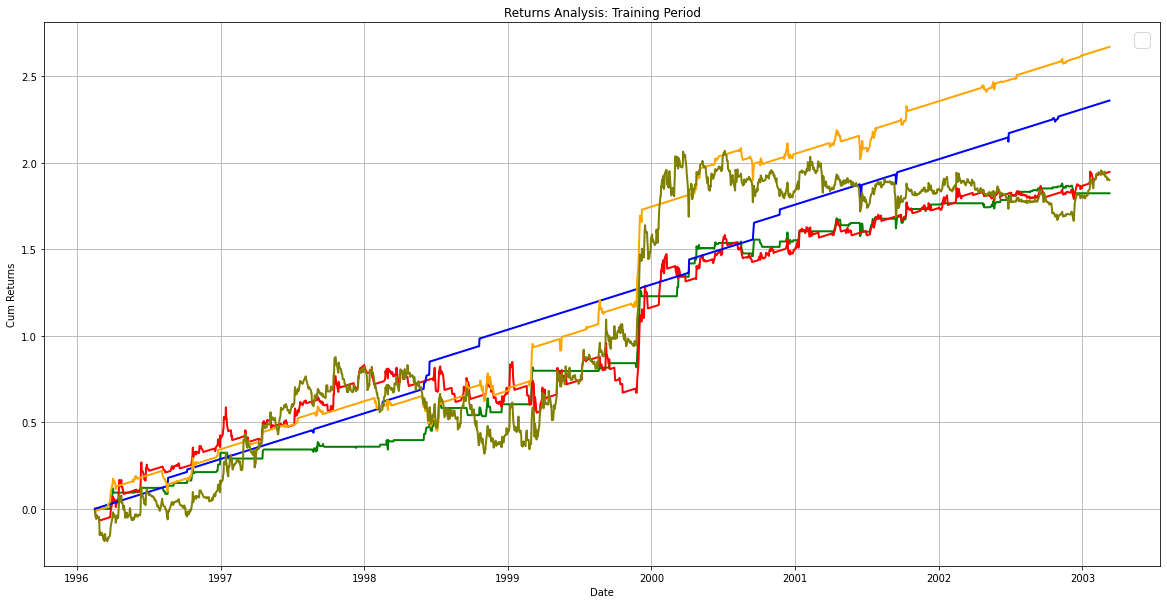

In [42]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(R1data.index, Cum_Return1, linewidth=2, color='green')
ax.plot(R1data.index, Cum_MACD1, linewidth=2, color='red')
ax.plot(R1data.index, Cum_RSI1, linewidth=2, color='blue')
ax.plot(R1data.index, Cum_BB1, linewidth=2, color='orange')
ax.plot(R1data.index, BH_Cum_Return1, linewidth=2, color='olive')

ax.set(xlabel='Date', ylabel='Cum Returns',
       title='Returns Analysis: Training Period')
ax.grid()

ax.legend(fontsize=20, loc=0)

plt.show()

Testing Period

In [43]:
Tdata = df_daily[-615:]
del Tdata ['Next Week Move']

inx = Tdata[['MACD', 'MHIST', 'RSI', 'BB', 'FI']]
inclose = Tdata['Close']

predictions =model.predict(inx)
Tdata['Predict'] = predictions

Rdata = Tdata[['Close', 'Predict', 'MACD', 'RSI', 'BB']]
Rdata['NextClose'] = Rdata['Close'].shift(-1)
Rdata.dropna(inplace=True)

#Strategy Return
Rdata['Strategy Return'] = Rdata.apply(lambda x : np.log(x['NextClose']/x['Close']) if x['Predict'] == 1 else 0, axis=1)
Total_Return = Rdata['Strategy Return'].sum()
Cum_Return = Rdata['Strategy Return'].cumsum()
print('The Total Return for the Strategy is:', Total_Return)

#MACD
Rdata['MACD Return'] = Rdata.apply(lambda x : np.log(x['NextClose']/x['Close']) if x['MACD'] == 1 else 0, axis=1)
Total_MACD = Rdata['MACD Return'].sum()
Cum_MACD = Rdata['MACD Return'].cumsum()
print('The Total Return for the MACD Strategy is:', Total_MACD)

#RSI
Rdata['RSI Return'] = Rdata.apply(lambda x : np.log(x['NextClose']/x['Close']) if x['RSI'] == 1 else 0, axis=1)
Total_RSI = Rdata['RSI Return'].sum()
Cum_RSI = Rdata['RSI Return'].cumsum()
print('The Total Return for the RSI Strategy is:', Total_RSI)
#BB
Rdata['BB Return'] = Rdata.apply(lambda x : np.log(x['NextClose']/x['Close']) if x['BB'] == 1 else 0, axis=1)
Total_BB = Rdata['BB Return'].sum()
Cum_BB = Rdata['BB Return'].cumsum()
print('The Total Return for the BB Strategy is:', Total_BB)

#Buy and Hold Return
Rdata['Buy & Hold Returns'] = np.log(Rdata['NextClose'] /Rdata['Close'])
BH_Return = Rdata['Buy & Hold Returns'].sum()
BH_Cum_Return = Rdata['Buy & Hold Returns'].cumsum()
print('The Buy and Hold Strategy Return is:', BH_Return)

The Total Return for the Strategy is: -0.031573954672511624
The Total Return for the MACD Strategy is: 0.19823398516982346
The Total Return for the RSI Strategy is: -0.2906933570504914
The Total Return for the BB Strategy is: 0.030856469755231833
The Buy and Hold Strategy Return is: 0.38200101608682147


Returns for testing period

No handles with labels found to put in legend.


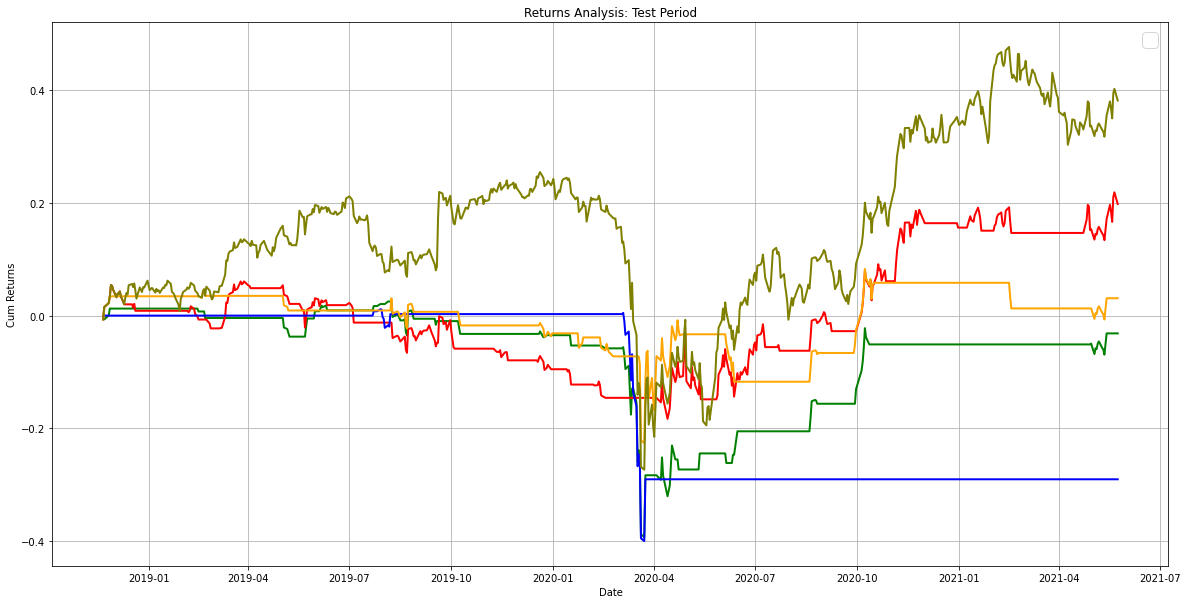

In [44]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(Rdata.index, Cum_Return, linewidth=2, color='green')
ax.plot(Rdata.index, Cum_MACD, linewidth=2, color='red')
ax.plot(Rdata.index, Cum_RSI, linewidth=2, color='blue')
ax.plot(Rdata.index, Cum_BB, linewidth=2, color='orange')
ax.plot(Rdata.index, BH_Cum_Return, linewidth=2, color='olive')


ax.set(xlabel='Date', ylabel='Cum Returns',
       title='Returns Analysis: Test Period')
ax.grid()

ax.legend(fontsize=20, loc=0)

plt.show()

In [46]:
model.score(x_test, y_test)

0.49559193954659947

In [48]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(model, x_train, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

array([[2017,  436],
       [1944,  367]], dtype=int64)

In [49]:
from sklearn.metrics import precision_score, recall_score
print("Precision: ", precision_score(y_train, y_train_pred))
print("Recall: ", recall_score(y_train, y_train_pred))

Precision:  0.45703611457036114
Recall:  0.15880571181306793


In [50]:
from sklearn.metrics import f1_score
f1_score(y_train, y_train_pred)


0.23570969813744377